# Contador de Células blancas

### Introducción

Un problema importante en el diagnóstico de la sangre es la clasificación de diferentes tipos de células sanguíneas. En este cuaderno, intentaremos entrenar a un clasificador para predecir el tipo de célula sanguínea a la que se le dará una imagen teñida.

### Datos

Tenemos 352 imágenes de glóbulos blancos teñidos junto con etiquetas de qué tipo de célula sanguínea son. A continuación se muestra un ejemplo de cada uno de los tipos de células sanguíneas en nuestro conjunto de datos.

#### Eosinófilo
![Eosinófilo](muestras/eosinofilo.jpg)

#### Linfocito
![Linfocito](muestras/linfocito.jpg)

#### Monocito
![Monocito](muestras/monocito.jpg)

#### Neutrófilo
![Neutrófilo](muestras/neutrofilo.jpg)

### Metodología

Utilizamos una arquitectura simple de LeNet entrenada en 281 muestras de entrenamiento con aumento de imagen. Nuestras técnicas de aumento incluyen rotaciones, cambios y acercamientos.

Validamos nuestros resultados contra 71 muestras.

### Resultados

En este modelo se entrenó una red convolucional usando el algortimo RMSprop, que cuenta con 3 capas convolucionales con activación tipo relu, con un pooling de 2x2. Dropout de 0.7 y se usa softmax al final para la clasificación. Este modelo clasifica entre 4 categorías que son: eosinófilo, linfocito, monocito y neutrófilo. Obteniendo resultados del 67% de presición.


# Code

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras import optimizers
import cv2
import scipy
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
num_classes = 4
epochs = 20
BASE_DIR = './'
batch_size = 32

In [6]:
model = Sequential()
model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [7]:
model.load_weights('modelo-2.h5')

In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 32)        0         
__________

In [9]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROFILO']:
                label = 'NEUTROFILO'

            elif wbc_type in ['EOSINOFILO']:
                label = 'EOSINOFILO'
            elif wbc_type in ['LINFOCITO']:
                label = 'LINFOCITO'
            else:
                label = 'MONOCITO'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)

    return X,y


## Presición

In [13]:
from sklearn.metrics import accuracy_score

X_train, y_train = get_data(BASE_DIR + '../docker/base-de-datos/entrenamiento/')
X_test, y_test = get_data(BASE_DIR + '../docker/base-de-datos/validacion-facil/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


print('Predicción...')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))


/Users/fran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Predicción...
0.676056338028169


# Imágenes mal clasificadas

In [30]:
mal_clasificado = np.intersect1d(np.where(y_pred == [0,0,0,1]), np.where(y_test == [0,0,1,0]))


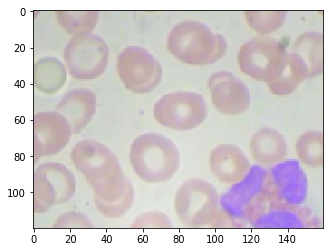

In [31]:
img = X_test[mal_clasificado[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Imágenes bien clasificadas

In [17]:
bien_clasificado = np.intersect1d(np.where(y_pred == [0,0,0,1]), np.where(y_test == [0,0,0,1]))

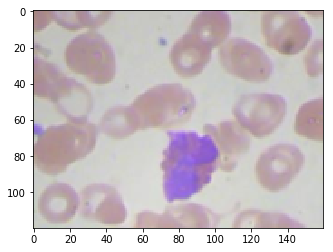

In [32]:
img = X_test[bien_clasificado[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))